# Overview

* To show the effectiveness of self-supervised tasks we consider a few-shot learning scenario consisting of 5, 10, 20, 50, and 100 shots training samples. We have a lot of unlabeled samples which is our test set. we make the auxiliary tasks using these unlabeled samples and compare the performance with these tasks:
    * Baseline(only main task)
    * Baseline + Rotation detection
    * Baseline + Bands detection
    * Baseline + Time-Segment detection
    * All tasks together
    
* To make the situation reflects real scenarios in few-shot learning we did not use any validation set to guide the training.

In [1]:
from utils import *

Numpy Version:  1.19.2
Tensorflow Version:  2.1.0


# Load Data

In [2]:
x_train = np.load('../data/source/x_train.npy')
y_train = np.load('../data/source/y_train.npy')
x_test = np.load('../data/source/x_test.npy')
y_test = np.load('../data/source/y_test.npy')
print(np.bincount(y_test.astype('int32')), y_test.dtype)
print(x_test.shape, x_test.dtype)
print(np.bincount(y_train.astype('int32')), y_train.dtype)
print(x_train.shape, x_train.dtype)

[300000 300000 300000 300000] float32
(1200000, 10, 7) float32
[100 100 100 100] float32
(400, 10, 7) float32


# Helper function to sample training data

In [3]:
def sample_few_train_set(few=5):
    
    w_ind = np.where(y_train==0)[0]
    c_ind = np.where(y_train==1)[0]
    r_ind = np.where(y_train==2)[0]
    o_ind = np.where(y_train==3)[0]

    x_w = x_train[w_ind]
    y_w = y_train[w_ind]
    
    x_c = x_train[c_ind]
    y_c = y_train[c_ind]
    
    x_r = x_train[r_ind]
    y_r = y_train[r_ind]
    
    x_o = x_train[o_ind]
    y_o = y_train[o_ind]

    x = np.concatenate([x_w[:few], x_c[:few], x_r[:few], x_o[:few]])
    y = np.concatenate([y_w[:few], y_c[:few], y_r[:few], y_o[:few]])
    
    return x, y

# Experiments

* I upsampled the few-shots by copying them to increase the batch size instead of the number of epochs. This makes the training faster, and it makes the impelementation of joint training with self-supervised tasks simpler.

## 5-shots

In [39]:
x_few, y_few = sample_few_train_set(few=5)
x_few_up = np.repeat(x_few, 600, axis=0)
y_few_up = np.repeat(y_few, 600, axis=0)
print(np.bincount(y_few_up.astype('int32')), x_few_up.shape, y_few_up.shape)

[3000 3000 3000 3000] (12000, 10, 7) (12000,)


### Baseline

In [19]:
def train_baseline(x_few_up, y_few_up, x_test, y_test, name='base_model_5shots_CM.png'):
    accuracies = []
    for trial in range(30):
        model = get_base_model()
        _ = model.fit(x_few_up, y_few_up, batch_size=2**12, epochs=20, verbose=0)
        acc = model.evaluate(x_test, y_test, batch_size=2**14, verbose=0)[1]
        accuracies.append(acc)
        print('run', trial, ': ', acc)
    accuracies = np.array(accuracies)
    print('mean src: ', np.mean(accuracies), '\t', 'std: ', np.std(accuracies, ddof=1))
    test_base_model(y_test, x_test, model=model, name=name)
    return accuracies, model

run 0 :  0.29540834
run 1 :  0.3283275
run 2 :  0.25002667
run 3 :  0.38332334
run 4 :  0.31106332
run 5 :  0.35480082
run 6 :  0.30220416
run 7 :  0.39935583
run 8 :  0.26682916
run 9 :  0.39361668
run 10 :  0.25323915
run 11 :  0.25140333
run 12 :  0.48743334
run 13 :  0.49911332
run 14 :  0.35233083
run 15 :  0.25080416
run 16 :  0.44681334
run 17 :  0.39811918
run 18 :  0.41431
run 19 :  0.25000167
run 20 :  0.33975834
run 21 :  0.34058082
run 22 :  0.40456918
run 23 :  0.40721667
run 24 :  0.416975
run 25 :  0.2651375
run 26 :  0.33969668
run 27 :  0.38577083
run 28 :  0.37538
run 29 :  0.3944525
mean src:  0.3519354 	 std:  0.07132636


C:\Users\houtan\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       wheat       0.72      0.73      0.72    300000
        corn       0.50      0.00      0.00    300000
        rice       0.00      0.00      0.00    300000
       other       0.28      0.85      0.43    300000

    accuracy                           0.39   1200000
   macro avg       0.38      0.39      0.29   1200000
weighted avg       0.38      0.39      0.29   1200000



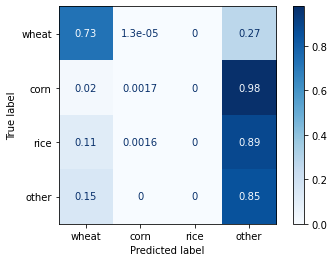

In [40]:
base_accs_5shots, base_model_5shots = train_baseline(x_few_up, y_few_up, x_test, 
                                                       y_test, name='base_model_5shots_CM.png')

### Rotation

In [5]:
class RotationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_few, y_few, x_unlabeled, batch_size=1000, oversample=False, repeat_size=100):
        self.x_few = x_few
        self.y_few = y_few
        self.x_unlabeled = x_unlabeled
        self.batch_size = batch_size
        
        # I can fix these labels since they are the same in each batch
        y_rot = np.ones((batch_size,), dtype='float32')
        y_not_rot = np.zeros((batch_size,), dtype='float32')
        y_aux = np.concatenate([y_rot, y_not_rot])
        # ignore value for rotation classification is 2:
        n1 = self.y_few.shape[0]
        n2 = y_aux.shape[0]
        y_dummy = np.zeros((n1,), dtype='float32') + 2.0
        y_aux = np.concatenate([y_dummy, y_aux])
        # ignore value for crop classification is 4:
        y_dummy = np.zeros((n2,), dtype='float32') + 4.0
        y_crop = np.concatenate([self.y_few, y_dummy])
        
        self.Y = [y_aux, y_crop]
        
    def __len__(self):
        return int(np.ceil(self.x_unlabeled.shape[0] / self.batch_size))
    
    def __getitem__(self, index):
        # auxiliary task
        x = self.x_unlabeled[index*self.batch_size:(index+1)*self.batch_size, :, :].copy()
        x_aux = np.concatenate([x[:, ::-1, :], x])
        # combine with the main task
        X = np.concatenate([self.x_few, x_aux])
        return X, self.Y
    
    def on_epoch_end(self):
        np.random.shuffle(self.x_unlabeled)

In [6]:
def train_rotation(x, y, x_test, y_test, name='rot_model_5shots_CM.png'):
    train_data_gen = RotationDataGenerator(x_few=x, y_few=y, x_unlabeled=x_test, batch_size=2000)
    accuracies = []
    for trial in range(30):
        model = get_rot_model()
        _ = model.fit(train_data_gen, epochs=20, verbose=0)
        acc = model.evaluate(x_test, [y_test, y_test], batch_size=2**14, verbose=0)[4]
        accuracies.append(acc)
        print('run', trial, ': ', acc)
    accuracies = np.array(accuracies)
    print('mean src: ', np.mean(accuracies), '\t', 'std: ', np.std(accuracies, ddof=1))
    test_single_task_model(y_test, x_test, model=model, name=name)
    return accuracies, model

run 0 :  0.8120025
run 1 :  0.825775
run 2 :  0.83482414
run 3 :  0.8534283
run 4 :  0.80712914
run 5 :  0.640315
run 6 :  0.82461417
run 7 :  0.8415908
run 8 :  0.8281825
run 9 :  0.82949084
run 10 :  0.83518916
run 11 :  0.8341325
run 12 :  0.798685
run 13 :  0.73457086
run 14 :  0.83949834
run 15 :  0.83333415
run 16 :  0.83437836
run 17 :  0.8252275
run 18 :  0.8123033
run 19 :  0.81928414
run 20 :  0.83232915
run 21 :  0.798075
run 22 :  0.7761925
run 23 :  0.84217834
run 24 :  0.8331775
run 25 :  0.78846836
run 26 :  0.830535
run 27 :  0.80075836
run 28 :  0.7960542
run 29 :  0.8013142
mean src:  0.8121013 	 std:  0.04039023
              precision    recall  f1-score   support

       wheat       0.94      0.65      0.77    300000
        corn       0.93      0.66      0.77    300000
        rice       0.87      0.98      0.92    300000
       other       0.62      0.91      0.74    300000

    accuracy                           0.80   1200000
   macro avg       0.84      0.80  

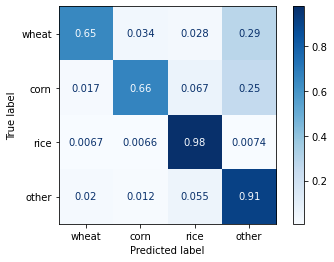

In [41]:
rot_accs_5shots, rot_model_5shots = train_rotation(x_few, y_few, x_test, 
                                                       y_test, name='rot_model_5shots_CM.png')

### Time-Segment

In [7]:
class SegmentDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_few, y_few, x_unlabeled, batch_size=2000):
        self.x_few = x_few
        self.y_few = y_few
        self.x_unlabeled = x_unlabeled
        self.batch_size = batch_size
        # I can fix these labels since they are the same in each batch
        y_seg_1 = np.zeros((batch_size,), dtype='float32')
        y_seg_2 = np.zeros((batch_size,), dtype='float32') + 1
        y_seg_3 = np.zeros((batch_size,), dtype='float32') + 2
        y_seg_4 = np.zeros((batch_size,), dtype='float32') + 3
        y_seg_5 = np.zeros((batch_size,), dtype='float32') + 4
        y_aux = np.concatenate([y_seg_1, y_seg_2, y_seg_3, y_seg_4, y_seg_5])
        n1 = self.y_few.shape[0]
        n2 = y_aux.shape[0]
        y_dummy = np.zeros((n1,), dtype='float32') + 5.0
        y_aux = np.concatenate([y_dummy, y_aux])
        y_dummy = np.zeros((n2,), dtype='float32') + 4.0
        y_crop = np.concatenate([self.y_few, y_dummy])
        self.Y = [y_aux, y_crop]
        
    def __len__(self):
        return int(np.ceil(self.x_unlabeled.shape[0] / self.batch_size))
    
    def __getitem__(self, index):
        # auxiliary task
        x = self.x_unlabeled[index*self.batch_size:(index+1)*self.batch_size, :, :].copy()
        x_seg_1 = np.repeat(x[:,:2,:], 5, axis=1)
        x_seg_2 = np.repeat(x[:,2:4,:], 5, axis=1)
        x_seg_3 = np.repeat(x[:,4:6,:], 5, axis=1)
        x_seg_4 = np.repeat(x[:,6:8,:], 5, axis=1)
        x_seg_5 = np.repeat(x[:,8:,:], 5, axis=1)
        x_aux = np.concatenate([x_seg_1, x_seg_2, x_seg_3, x_seg_4, x_seg_5])
        # combine with the main task
        X = np.concatenate([self.x_few, x_aux])
        return X, self.Y
    
    def on_epoch_end(self):
        np.random.shuffle(self.x_unlabeled)

In [8]:
def train_segment(x, y, x_test, y_test, name='seg_model_5shots_CM.png'):
    train_data_gen = SegmentDataGenerator(x_few=x, y_few=y, x_unlabeled=x_test, batch_size=2000)
    accuracies = []
    for trial in range(30):
        model = get_seg_model()
        _ = model.fit(train_data_gen, epochs=20, verbose=0)
        acc = model.evaluate(x_test, [y_test, y_test], batch_size=2**14, verbose=0)[4]
        accuracies.append(acc)
        print('run', trial, ': ', acc)
    accuracies = np.array(accuracies)
    print('mean src: ', np.mean(accuracies), '\t', 'std: ', np.std(accuracies, ddof=1))
    test_single_task_model(y_test, x_test, model=model, name=name)
    return accuracies, model

run 0 :  0.8233633
run 1 :  0.83229333
run 2 :  0.8396133
run 3 :  0.82097834
run 4 :  0.83073336
run 5 :  0.7850083
run 6 :  0.85889333
run 7 :  0.8028975
run 8 :  0.84258586
run 9 :  0.8070742
run 10 :  0.77207834
run 11 :  0.844585
run 12 :  0.8244017
run 13 :  0.77655584
run 14 :  0.84722084
run 15 :  0.8173108
run 16 :  0.83336836
run 17 :  0.83368164
run 18 :  0.85718
run 19 :  0.78643
run 20 :  0.805495
run 21 :  0.807825
run 22 :  0.8353158
run 23 :  0.8230992
run 24 :  0.8532842
run 25 :  0.8555
run 26 :  0.8205867
run 27 :  0.8176775
run 28 :  0.85417336
run 29 :  0.8633875
mean src:  0.82575333 	 std:  0.024799258
              precision    recall  f1-score   support

       wheat       0.91      0.79      0.85    300000
        corn       0.95      0.74      0.83    300000
        rice       0.92      0.98      0.95    300000
       other       0.73      0.94      0.82    300000

    accuracy                           0.86   1200000
   macro avg       0.88      0.86      0.

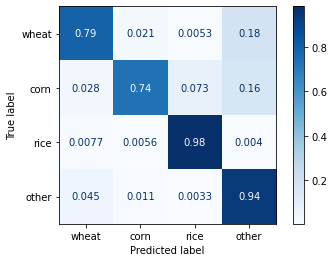

In [42]:
seg_accs_5shots, seg_model_5shots = train_segment(x_few, y_few, x_test, 
                                                       y_test, name='seg_model_5shots_CM.png')

### Bands

In [9]:
class BandDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_few, y_few, x_unlabeled, batch_size=2000):
        self.x_few = x_few
        self.y_few = y_few
        self.x_unlabeled = x_unlabeled
        self.batch_size = batch_size
        # I can fix these labels since they are the same in each batch
        y0 = np.zeros((batch_size,), dtype='float32')
        y1 = np.ones((batch_size,), dtype='float32')
        y2 = np.ones((batch_size,), dtype='float32') * 2
        y3 = np.ones((batch_size,), dtype='float32') * 3
        y4 = np.ones((batch_size,), dtype='float32') * 4
        y5 = np.ones((batch_size,), dtype='float32') * 5
        y6 = np.ones((batch_size,), dtype='float32') * 6    
        y_aux = np.concatenate([y0, y1, y2, y3, y4, y5, y6])
        n1 = self.y_few.shape[0]
        n2 = y_aux.shape[0]
        y_dummy = np.zeros((n1,), dtype='float32') + 7.0
        y_aux = np.concatenate([y_dummy, y_aux])
        y_dummy = np.zeros((n2,), dtype='float32') + 4.0
        y_crop = np.concatenate([self.y_few, y_dummy])
        self.Y = [y_aux, y_crop]
        
    def __len__(self):
        return int(np.ceil(self.x_unlabeled.shape[0] / self.batch_size))
    
    def __getitem__(self, index):
        # auxiliary task
        x = self.x_unlabeled[index*self.batch_size:(index+1)*self.batch_size, :, :].copy()
        b0 = np.repeat(x[:,:,0:1], 7, axis=-1)
        b1 = np.repeat(x[:,:,1:2], 7, axis=-1)
        b2 = np.repeat(x[:,:,2:3], 7, axis=-1)
        b3 = np.repeat(x[:,:,3:4], 7, axis=-1)
        b4 = np.repeat(x[:,:,4:5], 7, axis=-1)
        b5 = np.repeat(x[:,:,5:6], 7, axis=-1)
        b6 = np.repeat(x[:,:,6:7], 7, axis=-1)
        x_aux = np.concatenate([b0, b1, b2, b3, b4, b5, b6])
        # combine with the main task
        X = np.concatenate([self.x_few, x_aux])
        return X, self.Y
    
    def on_epoch_end(self):
        np.random.shuffle(self.x_unlabeled)

In [10]:
def train_band(x, y, x_test, y_test, name='band_model_5shots_CM.png'):
    train_data_gen = BandDataGenerator(x_few=x, y_few=y, x_unlabeled=x_test, batch_size=2000)
    accuracies = []
    for trial in range(30):
        model = get_band_model()
        _ = model.fit(train_data_gen, epochs=20, verbose=0)
        acc = model.evaluate(x_test, [y_test, y_test], batch_size=2**14, verbose=0)[4]
        accuracies.append(acc)
        print('run', trial, ': ', acc)
    accuracies = np.array(accuracies)
    print('mean src: ', np.mean(accuracies), '\t', 'std: ', np.std(accuracies, ddof=1))
    test_single_task_model(y_test, x_test, model=model, name=name)
    return accuracies, model

run 0 :  0.84261835
run 1 :  0.8214375
run 2 :  0.820365
run 3 :  0.81663084
run 4 :  0.81281835
run 5 :  0.8223233
run 6 :  0.82586664
run 7 :  0.8083208
run 8 :  0.85305417
run 9 :  0.82152164
run 10 :  0.84681416
run 11 :  0.80363667
run 12 :  0.83007
run 13 :  0.8377042
run 14 :  0.82104
run 15 :  0.8159867
run 16 :  0.81975836
run 17 :  0.82608086
run 18 :  0.814785
run 19 :  0.82461584
run 20 :  0.8408475
run 21 :  0.835965
run 22 :  0.8384675
run 23 :  0.8289033
run 24 :  0.84639585
run 25 :  0.82605916
run 26 :  0.8380258
run 27 :  0.85622
run 28 :  0.8197825
run 29 :  0.83649915
mean src:  0.82842046 	 std:  0.013100912
              precision    recall  f1-score   support

       wheat       0.77      0.86      0.82    300000
        corn       0.93      0.77      0.84    300000
        rice       0.97      0.96      0.97    300000
       other       0.70      0.76      0.73    300000

    accuracy                           0.84   1200000
   macro avg       0.85      0.84    

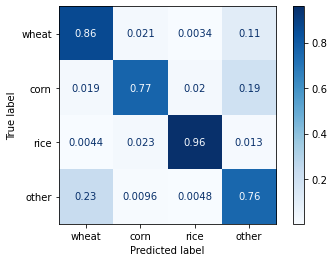

In [43]:
band_accs_5shots, band_model_5shots = train_band(x_few, y_few, x_test, 
                                                       y_test, name='band_model_5shots_CM.png')

### All tasks together

* We have crop classification, rotation detection, band detection, and time-segment detection tasks.

In [11]:
class MultiTaskDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_few, y_few, x_unlabeled, batch_size=2000):
        self.x_few = x_few
        self.y_few = y_few
        self.x_unlabeled = x_unlabeled
        self.batch_size = batch_size
        n1 = self.y_few.shape[0]
        # Bands:
        y0 = np.zeros((batch_size,), dtype='float32')
        y1 = np.ones((batch_size,), dtype='float32')
        y2 = np.ones((batch_size,), dtype='float32') * 2
        y3 = np.ones((batch_size,), dtype='float32') * 3
        y4 = np.ones((batch_size,), dtype='float32') * 4
        y5 = np.ones((batch_size,), dtype='float32') * 5
        y6 = np.ones((batch_size,), dtype='float32') * 6    
        y_bands = np.concatenate([y0, y1, y2, y3, y4, y5, y6])
        n2 = y_bands.shape[0]
        # Time-Segment:
        y_seg_1 = np.zeros((batch_size,), dtype='float32')
        y_seg_2 = np.zeros((batch_size,), dtype='float32') + 1
        y_seg_3 = np.zeros((batch_size,), dtype='float32') + 2
        y_seg_4 = np.zeros((batch_size,), dtype='float32') + 3
        y_seg_5 = np.zeros((batch_size,), dtype='float32') + 4
        y_segs = np.concatenate([y_seg_1, y_seg_2, y_seg_3, y_seg_4, y_seg_5])
        n3 = y_segs.shape[0]
        # Rotation:
        y_rot = np.ones((batch_size,), dtype='float32')
        y_not_rot = np.zeros((batch_size,), dtype='float32')
        y_rotation = np.concatenate([y_rot, y_not_rot])
        n4 = y_rotation.shape[0]
        # combine:
        y_dummy = np.zeros((n2 + n3 + n4,), dtype='float32') + 4.0
        y_crop = np.concatenate([self.y_few, y_dummy])

        # ignore value for band classification is 7:
        y_dummy = np.zeros((n1,), dtype='float32') + 7.0
        y_bands = np.concatenate([y_dummy, y_bands])
        y_dummy = np.zeros((n3 + n4,), dtype='float32') + 7.0
        y_bands = np.concatenate([y_bands, y_dummy])

        # ignore value for time-segment classification is 5:
        y_dummy = np.zeros((n1 + n2,), dtype='float32') + 5.0
        y_segs = np.concatenate([y_dummy, y_segs])
        y_dummy = np.zeros((n4,), dtype='float32') + 5.0
        y_segs = np.concatenate([y_segs, y_dummy])

        # ignore value for rotation classification is 2:
        y_dummy = np.zeros((n1 + n2 + n3,), dtype='float32') + 2.0
        y_rotation = np.concatenate([y_dummy, y_rotation])
        
        self.Y = [y_segs, y_bands, y_rotation, y_crop]
        
    def __len__(self):
        return int(np.ceil(self.x_unlabeled.shape[0] / self.batch_size))
    
    def __getitem__(self, index):
        # rotation task
        x = self.x_unlabeled[index*self.batch_size:(index+1)*self.batch_size, :, :].copy()
        x_rot = np.concatenate([x[:, ::-1, :], x])
        # band task
        b0 = np.repeat(x[:,:,0:1], 7, axis=-1)
        b1 = np.repeat(x[:,:,1:2], 7, axis=-1)
        b2 = np.repeat(x[:,:,2:3], 7, axis=-1)
        b3 = np.repeat(x[:,:,3:4], 7, axis=-1)
        b4 = np.repeat(x[:,:,4:5], 7, axis=-1)
        b5 = np.repeat(x[:,:,5:6], 7, axis=-1)
        b6 = np.repeat(x[:,:,6:7], 7, axis=-1)
        x_band = np.concatenate([b0, b1, b2, b3, b4, b5, b6])
        # time-segment
        x_seg_1 = np.repeat(x[:,:2,:], 5, axis=1)
        x_seg_2 = np.repeat(x[:,2:4,:], 5, axis=1)
        x_seg_3 = np.repeat(x[:,4:6,:], 5, axis=1)
        x_seg_4 = np.repeat(x[:,6:8,:], 5, axis=1)
        x_seg_5 = np.repeat(x[:,8:,:], 5, axis=1)
        x_seg = np.concatenate([x_seg_1, x_seg_2, x_seg_3, x_seg_4, x_seg_5])
        # combine with the main task
        X = np.concatenate([self.x_few, x_band, x_seg, x_rot])
        return X, self.Y
    
    def on_epoch_end(self):
        np.random.shuffle(self.x_unlabeled)

In [12]:
def train_multitask(x, y, x_test, y_test, name='all_model_5shots_CM.png'):
    train_data_gen = MultiTaskDataGenerator(x_few=x, y_few=y, x_unlabeled=x_test, batch_size=1000)
    accuracies = []
    for trial in range(30):
        model = get_one_for_all_model()
        _ = model.fit(train_data_gen, epochs=10, verbose=0)
        acc = model.evaluate(x_test, [y_test, y_test, y_test, y_test], batch_size=2**14, verbose=0)[8]
        accuracies.append(acc)
        print('run', trial, ': ', acc)
    accuracies = np.array(accuracies)
    print('mean src: ', np.mean(accuracies), '\t', 'std: ', np.std(accuracies, ddof=1))
    test_multitask_model(y_test, x_test, model=model, name=name)
    return accuracies, model

run 0 :  0.83893085
run 1 :  0.6239325
run 2 :  0.85575664
run 3 :  0.85109335
run 4 :  0.8334733
run 5 :  0.73335165
run 6 :  0.82243
run 7 :  0.77884
run 8 :  0.8312
run 9 :  0.8299025
run 10 :  0.85257417
run 11 :  0.813765
run 12 :  0.8066433
run 13 :  0.7901817
run 14 :  0.81100667
run 15 :  0.82546836
run 16 :  0.8312975
run 17 :  0.837325
run 18 :  0.85705084
run 19 :  0.8250908
run 20 :  0.82878584
run 21 :  0.7968558
run 22 :  0.83921164
run 23 :  0.8234875
run 24 :  0.8172708
run 25 :  0.8539733
run 26 :  0.80932665
run 27 :  0.8563092
run 28 :  0.83190167
run 29 :  0.842165
mean src:  0.8182867 	 std:  0.045065783
              precision    recall  f1-score   support

       wheat       0.86      0.83      0.84    300000
        corn       0.95      0.67      0.79    300000
        rice       0.96      0.95      0.95    300000
       other       0.69      0.92      0.79    300000

    accuracy                           0.84   1200000
   macro avg       0.86      0.84      0.

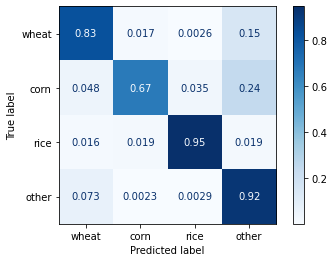

In [44]:
mt_accs_5shots, mt_model_5shots = train_multitask(x_few, y_few, x_test, 
                                                       y_test, name='all_model_5shots_CM.png')

## 10-shots

In [13]:
x_few, y_few = sample_few_train_set(few=10)
x_few_up = np.repeat(x_few, 600, axis=0)
y_few_up = np.repeat(y_few, 600, axis=0)
print(np.bincount(y_few_up.astype('int32')), x_few_up.shape, y_few_up.shape)

[6000 6000 6000 6000] (24000, 10, 7) (24000,)


### Baseline

run 0 :  0.248555
run 1 :  0.24860084
run 2 :  0.25020167
run 3 :  0.2487225
run 4 :  0.24999833
run 5 :  0.24999084
run 6 :  0.24853083
run 7 :  0.24832417
run 8 :  0.24998833
run 9 :  0.25279585
run 10 :  0.24999583
run 11 :  0.24848667
run 12 :  0.24999417
run 13 :  0.24889167
run 14 :  0.2499975
run 15 :  0.24938083
run 16 :  0.2499825
run 17 :  0.24967083
run 18 :  0.2486475
run 19 :  0.25
run 20 :  0.24916333
run 21 :  0.2487125
run 22 :  0.24885583
run 23 :  0.24833333
run 24 :  0.24924916
run 25 :  0.2499975
run 26 :  0.2499625
run 27 :  0.24999167
run 28 :  0.24999666
run 29 :  0.24826
mean src:  0.2494426 	 std:  0.0009295727


C:\Users\houtan\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       wheat       0.02      0.00      0.00    300000
        corn       0.28      0.01      0.01    300000
        rice       0.00      0.00      0.00    300000
       other       0.25      0.99      0.40    300000

    accuracy                           0.25   1200000
   macro avg       0.14      0.25      0.10   1200000
weighted avg       0.14      0.25      0.10   1200000



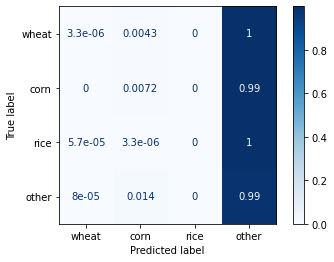

In [20]:
base_accs_10shots, base_model_10shots = train_baseline(x_few_up, y_few_up, x_test, 
                                                       y_test, name='base_model_10shots_CM.png')

### Rotation

run 0 :  0.86351085
run 1 :  0.84007585
run 2 :  0.8221358
run 3 :  0.8439975
run 4 :  0.85178834
run 5 :  0.83997583
run 6 :  0.8379833
run 7 :  0.8101025
run 8 :  0.8341925
run 9 :  0.82691085
run 10 :  0.84873915
run 11 :  0.8077192
run 12 :  0.856345
run 13 :  0.86058915
run 14 :  0.84696335
run 15 :  0.8462925
run 16 :  0.8524525
run 17 :  0.8514683
run 18 :  0.8393342
run 19 :  0.84371084
run 20 :  0.68153834
run 21 :  0.82513165
run 22 :  0.805705
run 23 :  0.83473164
run 24 :  0.83336085
run 25 :  0.83877
run 26 :  0.8349792
run 27 :  0.82385665
run 28 :  0.85190165
run 29 :  0.84895164
mean src:  0.8334405 	 std:  0.032230653
              precision    recall  f1-score   support

       wheat       0.78      0.88      0.82    300000
        corn       0.88      0.86      0.87    300000
        rice       0.97      0.97      0.97    300000
       other       0.77      0.69      0.73    300000

    accuracy                           0.85   1200000
   macro avg       0.85      0.

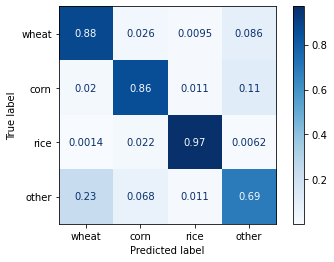

In [15]:
rot_accs_10shots, rot_model_10shots = train_rotation(x_few, y_few, x_test, 
                                                       y_test, name='rot_model_10shots_CM.png')

### Time-Segment

run 0 :  0.887985
run 1 :  0.8711658
run 2 :  0.8560375
run 3 :  0.88259834
run 4 :  0.8698425
run 5 :  0.8373092
run 6 :  0.87113583
run 7 :  0.875315
run 8 :  0.869395
run 9 :  0.87998164
run 10 :  0.85748833
run 11 :  0.88138086
run 12 :  0.8949958
run 13 :  0.8703967
run 14 :  0.8754258
run 15 :  0.8763767
run 16 :  0.8760975
run 17 :  0.88172
run 18 :  0.8856842
run 19 :  0.89424664
run 20 :  0.87841415
run 21 :  0.8677058
run 22 :  0.872695
run 23 :  0.88134086
run 24 :  0.8669083
run 25 :  0.8720642
run 26 :  0.8795717
run 27 :  0.87724084
run 28 :  0.8812467
run 29 :  0.8758125
mean src:  0.8749193 	 std:  0.011250114
              precision    recall  f1-score   support

       wheat       0.82      0.86      0.84    300000
        corn       0.91      0.89      0.90    300000
        rice       0.98      0.97      0.97    300000
       other       0.79      0.78      0.79    300000

    accuracy                           0.88   1200000
   macro avg       0.88      0.88      0

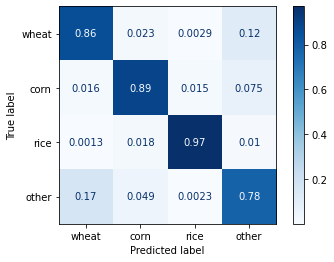

In [16]:
seg_accs_10shots, seg_model_10shots = train_segment(x_few, y_few, x_test, 
                                                       y_test, name='seg_model_10shots_CM.png')

### Bands

run 0 :  0.8376325
run 1 :  0.8344542
run 2 :  0.8425417
run 3 :  0.83376
run 4 :  0.8471492
run 5 :  0.82877666
run 6 :  0.84107333
run 7 :  0.83893085
run 8 :  0.84721917
run 9 :  0.8394283
run 10 :  0.82344085
run 11 :  0.837945
run 12 :  0.8349392
run 13 :  0.8437075
run 14 :  0.83624667
run 15 :  0.840165
run 16 :  0.8376858
run 17 :  0.8422167
run 18 :  0.82739
run 19 :  0.84337586
run 20 :  0.8391025
run 21 :  0.84635085
run 22 :  0.8210792
run 23 :  0.83142835
run 24 :  0.83606166
run 25 :  0.8340908
run 26 :  0.82299834
run 27 :  0.8262042
run 28 :  0.84669167
run 29 :  0.82475585
mean src:  0.8362281 	 std:  0.007608764
              precision    recall  f1-score   support

       wheat       0.74      0.87      0.80    300000
        corn       0.86      0.83      0.85    300000
        rice       0.97      0.97      0.97    300000
       other       0.74      0.63      0.68    300000

    accuracy                           0.82   1200000
   macro avg       0.83      0.82   

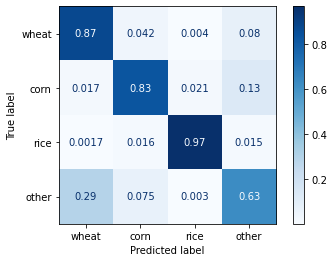

In [17]:
band_accs_10shots, band_model_10shots = train_band(x_few, y_few, x_test, 
                                                       y_test, name='band_model_10shots_CM.png')

### All tasks

run 0 :  0.85882914
run 1 :  0.8473125
run 2 :  0.861035
run 3 :  0.8565175
run 4 :  0.8344733
run 5 :  0.8644225
run 6 :  0.86907417
run 7 :  0.8512025
run 8 :  0.8638975
run 9 :  0.84160584
run 10 :  0.8410183
run 11 :  0.83053166
run 12 :  0.8391258
run 13 :  0.84519917
run 14 :  0.8408567
run 15 :  0.8594267
run 16 :  0.8445992
run 17 :  0.85285586
run 18 :  0.85075665
run 19 :  0.79010415
run 20 :  0.8476625
run 21 :  0.854645
run 22 :  0.8618442
run 23 :  0.86034834
run 24 :  0.85253
run 25 :  0.8604183
run 26 :  0.8491325
run 27 :  0.88095
run 28 :  0.85430664
run 29 :  0.86198664
mean src:  0.85088897 	 std:  0.015770737
              precision    recall  f1-score   support

       wheat       0.77      0.87      0.82    300000
        corn       0.94      0.86      0.90    300000
        rice       0.97      0.97      0.97    300000
       other       0.78      0.74      0.76    300000

    accuracy                           0.86   1200000
   macro avg       0.87      0.86    

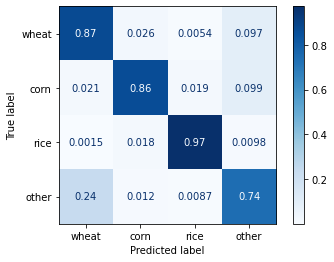

In [18]:
mt_accs_10shots, mt_model_10shots = train_multitask(x_few, y_few, x_test, 
                                                       y_test, name='all_model_10shots_CM.png')

## 20 shots

In [21]:
x_few, y_few = sample_few_train_set(few=20)
x_few_up = np.repeat(x_few, 600, axis=0)
y_few_up = np.repeat(y_few, 600, axis=0)
print(np.bincount(y_few_up.astype('int32')), x_few_up.shape, y_few_up.shape)

[12000 12000 12000 12000] (48000, 10, 7) (48000,)


### Baseline

run 0 :  0.25813666
run 1 :  0.24982166
run 2 :  0.25018167
run 3 :  0.2499625
run 4 :  0.250335
run 5 :  0.24961166
run 6 :  0.2550125
run 7 :  0.2499175
run 8 :  0.249635
run 9 :  0.2499575
run 10 :  0.2481825
run 11 :  0.25023
run 12 :  0.26424918
run 13 :  0.33692
run 14 :  0.29819417
run 15 :  0.24956167
run 16 :  0.24992
run 17 :  0.25024083
run 18 :  0.24973917
run 19 :  0.26237
run 20 :  0.2599
run 21 :  0.2499175
run 22 :  0.24848416
run 23 :  0.25017667
run 24 :  0.25003
run 25 :  0.24999334
run 26 :  0.24976334
run 27 :  0.2499425
run 28 :  0.24994166
run 29 :  0.25453168
mean src:  0.25616202 	 std:  0.01791853
              precision    recall  f1-score   support

       wheat       0.29      0.00      0.00    300000
        corn       0.06      0.04      0.05    300000
        rice       0.05      0.00      0.00    300000
       other       0.30      0.98      0.46    300000

    accuracy                           0.25   1200000
   macro avg       0.17      0.25      0.13

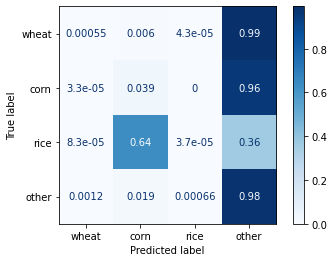

In [22]:
base_accs_20shots, base_model_20shots = train_baseline(x_few_up, y_few_up, x_test, 
                                                       y_test, name='base_model_20shots_CM.png')

### Rotation

run 0 :  0.8734108
run 1 :  0.8497392
run 2 :  0.8685825
run 3 :  0.8636708
run 4 :  0.87614083
run 5 :  0.85122836
run 6 :  0.85174084
run 7 :  0.84314585
run 8 :  0.8634692
run 9 :  0.8721258
run 10 :  0.838505
run 11 :  0.8681175
run 12 :  0.8546583
run 13 :  0.8398975
run 14 :  0.8742
run 15 :  0.8547083
run 16 :  0.8401908
run 17 :  0.85749584
run 18 :  0.856385
run 19 :  0.8591742
run 20 :  0.86268085
run 21 :  0.83658415
run 22 :  0.86408335
run 23 :  0.86122084
run 24 :  0.8641858
run 25 :  0.85810083
run 26 :  0.8639167
run 27 :  0.85661
run 28 :  0.8727175
run 29 :  0.8547342
mean src:  0.8583807 	 std:  0.01107363
              precision    recall  f1-score   support

       wheat       0.83      0.83      0.83    300000
        corn       0.92      0.79      0.85    300000
        rice       0.96      0.97      0.96    300000
       other       0.73      0.83      0.78    300000

    accuracy                           0.85   1200000
   macro avg       0.86      0.85      0.

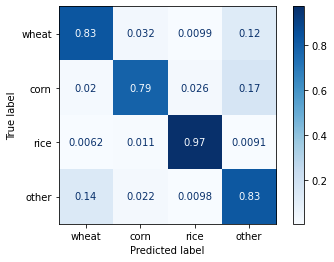

In [23]:
rot_accs_20shots, rot_model_20shots = train_rotation(x_few, y_few, x_test, 
                                                       y_test, name='rot_model_20shots_CM.png')

### Time-Segment

run 0 :  0.9040642
run 1 :  0.88958836
run 2 :  0.895035
run 3 :  0.9035083
run 4 :  0.895025
run 5 :  0.9050342
run 6 :  0.90117
run 7 :  0.90129083
run 8 :  0.8651742
run 9 :  0.8965175
run 10 :  0.89084
run 11 :  0.807335
run 12 :  0.90418917
run 13 :  0.9061475
run 14 :  0.8837467
run 15 :  0.9014767
run 16 :  0.8985742
run 17 :  0.88103
run 18 :  0.8999175
run 19 :  0.9016683
run 20 :  0.9074842
run 21 :  0.8907292
run 22 :  0.90079165
run 23 :  0.8738475
run 24 :  0.76963836
run 25 :  0.9009025
run 26 :  0.8940692
run 27 :  0.8849858
run 28 :  0.9017367
run 29 :  0.90301585
mean src:  0.88861775 	 std:  0.02936373
              precision    recall  f1-score   support

       wheat       0.91      0.87      0.89    300000
        corn       0.94      0.87      0.90    300000
        rice       0.98      0.96      0.97    300000
       other       0.80      0.91      0.85    300000

    accuracy                           0.90   1200000
   macro avg       0.91      0.90      0.90   

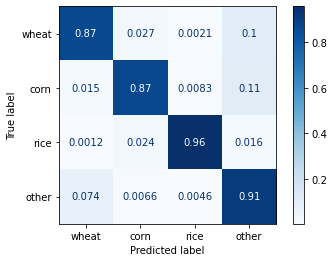

In [24]:
seg_accs_20shots, seg_model_20shots = train_segment(x_few, y_few, x_test, 
                                                       y_test, name='seg_model_20shots_CM.png')

### Bands

run 0 :  0.8559175
run 1 :  0.88402915
run 2 :  0.8734767
run 3 :  0.87772
run 4 :  0.86954916
run 5 :  0.87008584
run 6 :  0.8586633
run 7 :  0.8804525
run 8 :  0.8633208
run 9 :  0.866495
run 10 :  0.8623875
run 11 :  0.8831375
run 12 :  0.8758575
run 13 :  0.87282
run 14 :  0.8609325
run 15 :  0.87577415
run 16 :  0.87085
run 17 :  0.86622417
run 18 :  0.8756317
run 19 :  0.8737133
run 20 :  0.866875
run 21 :  0.8615475
run 22 :  0.8560258
run 23 :  0.86941916
run 24 :  0.8589375
run 25 :  0.87466335
run 26 :  0.8668892
run 27 :  0.8707975
run 28 :  0.860975
run 29 :  0.87569666
mean src:  0.86929554 	 std:  0.0077478136
              precision    recall  f1-score   support

       wheat       0.87      0.84      0.86    300000
        corn       0.88      0.89      0.88    300000
        rice       0.96      0.94      0.95    300000
       other       0.80      0.83      0.82    300000

    accuracy                           0.88   1200000
   macro avg       0.88      0.88      0.8

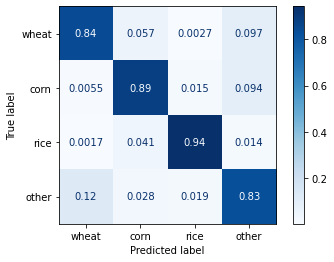

In [25]:
band_accs_20shots, band_model_20shots = train_band(x_few, y_few, x_test, 
                                                       y_test, name='band_model_20shots_CM.png')

### All tasks

run 0 :  0.8890475
run 1 :  0.88641334
run 2 :  0.8691225
run 3 :  0.8807908
run 4 :  0.8868375
run 5 :  0.8922358
run 6 :  0.88141
run 7 :  0.8879667
run 8 :  0.88919085
run 9 :  0.89849
run 10 :  0.8858075
run 11 :  0.85099834
run 12 :  0.8867525
run 13 :  0.8805683
run 14 :  0.8983267
run 15 :  0.8944992
run 16 :  0.88446164
run 17 :  0.8918008
run 18 :  0.89560336
run 19 :  0.89791834
run 20 :  0.8853008
run 21 :  0.8874058
run 22 :  0.8907767
run 23 :  0.88716
run 24 :  0.87436086
run 25 :  0.8839267
run 26 :  0.85154665
run 27 :  0.88083833
run 28 :  0.89347416
run 29 :  0.8906033
mean src:  0.8851212 	 std:  0.011349915
              precision    recall  f1-score   support

       wheat       0.90      0.83      0.87    300000
        corn       0.92      0.88      0.90    300000
        rice       0.97      0.95      0.96    300000
       other       0.79      0.90      0.84    300000

    accuracy                           0.89   1200000
   macro avg       0.89      0.89      

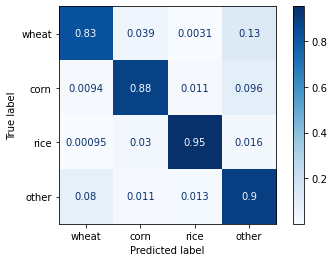

In [26]:
mt_accs_20shots, mt_model_20shots = train_multitask(x_few, y_few, x_test, 
                                                       y_test, name='all_model_20shots_CM.png')

## 50 shots

In [27]:
x_few, y_few = sample_few_train_set(few=50)
x_few_up = np.repeat(x_few, 600, axis=0)
y_few_up = np.repeat(y_few, 600, axis=0)
print(np.bincount(y_few_up.astype('int32')), x_few_up.shape, y_few_up.shape)

[30000 30000 30000 30000] (120000, 10, 7) (120000,)


### Baseline

run 0 :  0.88396335
run 1 :  0.88493085
run 2 :  0.8835292
run 3 :  0.88445586
run 4 :  0.8714592
run 5 :  0.8831817
run 6 :  0.88648665
run 7 :  0.89509
run 8 :  0.88362664
run 9 :  0.8758542
run 10 :  0.8863675
run 11 :  0.8859108
run 12 :  0.8808725
run 13 :  0.88686335
run 14 :  0.878235
run 15 :  0.88654
run 16 :  0.87807417
run 17 :  0.8789808
run 18 :  0.8740575
run 19 :  0.87691
run 20 :  0.88184667
run 21 :  0.88727915
run 22 :  0.88585085
run 23 :  0.8790417
run 24 :  0.8848075
run 25 :  0.8763242
run 26 :  0.8801567
run 27 :  0.8791742
run 28 :  0.87709916
run 29 :  0.887445
mean src:  0.8821472 	 std:  0.0050130314
              precision    recall  f1-score   support

       wheat       0.90      0.85      0.87    300000
        corn       0.87      0.89      0.88    300000
        rice       0.99      0.91      0.95    300000
       other       0.80      0.90      0.85    300000

    accuracy                           0.89   1200000
   macro avg       0.89      0.89      

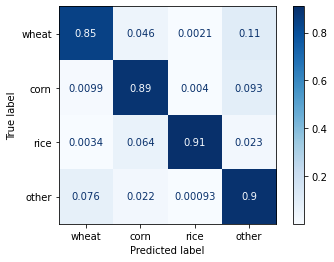

In [28]:
base_accs_50shots, base_model_50shots = train_baseline(x_few_up, y_few_up, x_test, 
                                                       y_test, name='base_model_50shots_CM.png')

### Rotation

run 0 :  0.92241335
run 1 :  0.904905
run 2 :  0.92008835
run 3 :  0.91341835
run 4 :  0.919945
run 5 :  0.9187275
run 6 :  0.91812086
run 7 :  0.9258717
run 8 :  0.919465
run 9 :  0.9111908
run 10 :  0.91774166
run 11 :  0.9174192
run 12 :  0.9188192
run 13 :  0.91869414
run 14 :  0.9237475
run 15 :  0.91803914
run 16 :  0.9196967
run 17 :  0.91739917
run 18 :  0.917195
run 19 :  0.91903335
run 20 :  0.92256165
run 21 :  0.91308665
run 22 :  0.91294914
run 23 :  0.92172664
run 24 :  0.9197275
run 25 :  0.9160658
run 26 :  0.9206875
run 27 :  0.9137025
run 28 :  0.91874415
run 29 :  0.92352915
mean src:  0.91815704 	 std:  0.004225572
              precision    recall  f1-score   support

       wheat       0.94      0.87      0.91    300000
        corn       0.92      0.92      0.92    300000
        rice       0.96      0.98      0.97    300000
       other       0.87      0.93      0.90    300000

    accuracy                           0.92   1200000
   macro avg       0.92      0.

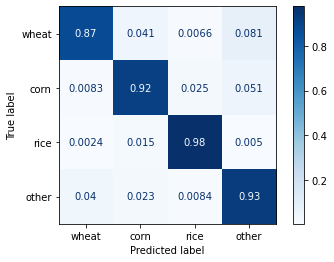

In [29]:
rot_accs_50shots, rot_model_50shots = train_rotation(x_few, y_few, x_test, 
                                                       y_test, name='rot_model_50shots_CM.png')

### Time-Segment

run 0 :  0.9155275
run 1 :  0.9268917
run 2 :  0.9165292
run 3 :  0.9238025
run 4 :  0.93049
run 5 :  0.92564166
run 6 :  0.92104584
run 7 :  0.9203183
run 8 :  0.9052175
run 9 :  0.93396
run 10 :  0.92852914
run 11 :  0.9070092
run 12 :  0.92348164
run 13 :  0.924815
run 14 :  0.92985916
run 15 :  0.9315375
run 16 :  0.91957664
run 17 :  0.93178165
run 18 :  0.922525
run 19 :  0.9178917
run 20 :  0.9282725
run 21 :  0.924245
run 22 :  0.92889166
run 23 :  0.9279075
run 24 :  0.93169916
run 25 :  0.9119192
run 26 :  0.9230925
run 27 :  0.932585
run 28 :  0.9049075
run 29 :  0.9274008
mean src:  0.9232451 	 std:  0.008034866
              precision    recall  f1-score   support

       wheat       0.95      0.87      0.91    300000
        corn       0.94      0.91      0.93    300000
        rice       0.98      0.97      0.97    300000
       other       0.85      0.96      0.90    300000

    accuracy                           0.93   1200000
   macro avg       0.93      0.93      0.9

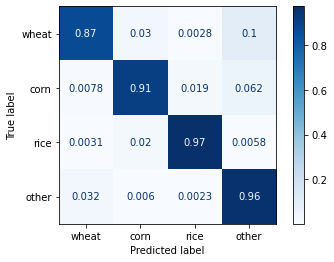

In [30]:
seg_accs_50shots, seg_model_50shots = train_segment(x_few, y_few, x_test, 
                                                       y_test, name='seg_model_50shots_CM.png')

### Bands

run 0 :  0.906165
run 1 :  0.9046892
run 2 :  0.90256333
run 3 :  0.90131
run 4 :  0.90995586
run 5 :  0.8988283
run 6 :  0.898515
run 7 :  0.9046483
run 8 :  0.90262836
run 9 :  0.90231
run 10 :  0.9005375
run 11 :  0.8982483
run 12 :  0.906185
run 13 :  0.9036475
run 14 :  0.903385
run 15 :  0.90104586
run 16 :  0.9032392
run 17 :  0.90593
run 18 :  0.9032583
run 19 :  0.908015
run 20 :  0.90190333
run 21 :  0.9038283
run 22 :  0.9054217
run 23 :  0.88657415
run 24 :  0.88852
run 25 :  0.9029692
run 26 :  0.90087414
run 27 :  0.90453833
run 28 :  0.9008217
run 29 :  0.899815
mean src:  0.90201247 	 std:  0.004777561
              precision    recall  f1-score   support

       wheat       0.91      0.86      0.89    300000
        corn       0.89      0.90      0.89    300000
        rice       0.98      0.95      0.96    300000
       other       0.83      0.89      0.86    300000

    accuracy                           0.90   1200000
   macro avg       0.90      0.90      0.90   12

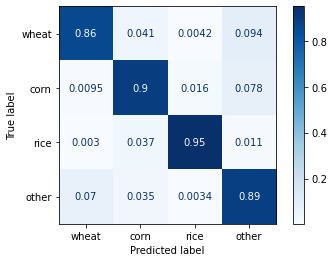

In [31]:
band_accs_50shots, band_model_50shots = train_band(x_few, y_few, x_test, 
                                                       y_test, name='band_model_50shots_CM.png')

### All tasks

run 0 :  0.906975
run 1 :  0.91833586
run 2 :  0.90949667
run 3 :  0.9230425
run 4 :  0.91156083
run 5 :  0.9097667
run 6 :  0.9208817
run 7 :  0.91131586
run 8 :  0.92676586
run 9 :  0.916275
run 10 :  0.9194975
run 11 :  0.9137883
run 12 :  0.92357165
run 13 :  0.93064165
run 14 :  0.92726916
run 15 :  0.9096558
run 16 :  0.9125675
run 17 :  0.9122508
run 18 :  0.92583835
run 19 :  0.91682166
run 20 :  0.92075086
run 21 :  0.92055583
run 22 :  0.9219392
run 23 :  0.9180125
run 24 :  0.90779084
run 25 :  0.9139392
run 26 :  0.92257583
run 27 :  0.9218575
run 28 :  0.91469085
run 29 :  0.9180858
mean src:  0.91755044 	 std:  0.0062815202
              precision    recall  f1-score   support

       wheat       0.95      0.85      0.90    300000
        corn       0.91      0.92      0.91    300000
        rice       0.97      0.96      0.97    300000
       other       0.85      0.95      0.90    300000

    accuracy                           0.92   1200000
   macro avg       0.92     

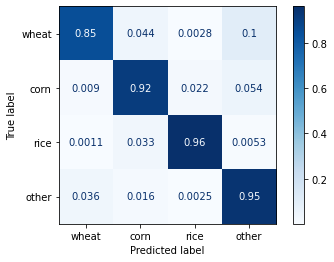

In [32]:
mt_accs_50shots, mt_model_50shots = train_multitask(x_few, y_few, x_test, 
                                                       y_test, name='all_model_50shots_CM.png')

## 100 shots

In [33]:
x_few, y_few = sample_few_train_set(few=100)
x_few_up = np.repeat(x_few, 600, axis=0)
y_few_up = np.repeat(y_few, 600, axis=0)
print(np.bincount(y_few_up.astype('int32')), x_few_up.shape, y_few_up.shape)

[60000 60000 60000 60000] (240000, 10, 7) (240000,)


### Baseline

run 0 :  0.9156042
run 1 :  0.9235525
run 2 :  0.9211658
run 3 :  0.91883
run 4 :  0.9210025
run 5 :  0.92454416
run 6 :  0.91439086
run 7 :  0.9215275
run 8 :  0.9198458
run 9 :  0.91942585
run 10 :  0.92369336
run 11 :  0.91907585
run 12 :  0.92059416
run 13 :  0.92384416
run 14 :  0.9214392
run 15 :  0.92134416
run 16 :  0.914005
run 17 :  0.9256775
run 18 :  0.9197208
run 19 :  0.92032915
run 20 :  0.91854084
run 21 :  0.91870916
run 22 :  0.92261666
run 23 :  0.9218425
run 24 :  0.92184
run 25 :  0.92106086
run 26 :  0.91883165
run 27 :  0.9234617
run 28 :  0.9239117
run 29 :  0.92146915
mean src:  0.9207299 	 std:  0.0027898406
              precision    recall  f1-score   support

       wheat       0.91      0.90      0.91    300000
        corn       0.90      0.94      0.92    300000
        rice       0.98      0.97      0.97    300000
       other       0.89      0.88      0.89    300000

    accuracy                           0.92   1200000
   macro avg       0.92      0.9

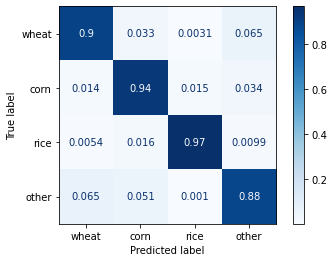

In [34]:
base_accs_100shots, base_model_100shots = train_baseline(x_few_up, y_few_up, x_test, 
                                                       y_test, name='base_model_100shots_CM.png')

### Rotation

run 0 :  0.9362675
run 1 :  0.93120915
run 2 :  0.935665
run 3 :  0.93153167
run 4 :  0.9336333
run 5 :  0.92535836
run 6 :  0.940455
run 7 :  0.93948334
run 8 :  0.93367666
run 9 :  0.93426335
run 10 :  0.9250075
run 11 :  0.93728834
run 12 :  0.94133586
run 13 :  0.9405225
run 14 :  0.9383992
run 15 :  0.93555
run 16 :  0.934995
run 17 :  0.93315
run 18 :  0.9369042
run 19 :  0.93758667
run 20 :  0.93701416
run 21 :  0.9381958
run 22 :  0.9344083
run 23 :  0.939475
run 24 :  0.9313575
run 25 :  0.9368625
run 26 :  0.93224585
run 27 :  0.9363242
run 28 :  0.9412517
run 29 :  0.94229585
mean src:  0.93572384 	 std:  0.004210297
              precision    recall  f1-score   support

       wheat       0.94      0.90      0.92    300000
        corn       0.95      0.94      0.94    300000
        rice       0.98      0.98      0.98    300000
       other       0.90      0.94      0.92    300000

    accuracy                           0.94   1200000
   macro avg       0.94      0.94     

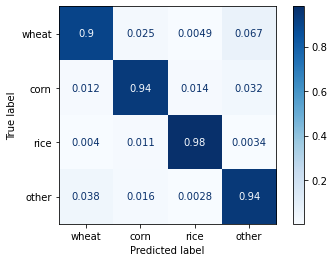

In [35]:
rot_accs_100shots, rot_model_100shots = train_rotation(x_few, y_few, x_test, 
                                                       y_test, name='rot_model_100shots_CM.png')

### Time-Segment

run 0 :  0.942195
run 1 :  0.94251084
run 2 :  0.9425258
run 3 :  0.94316083
run 4 :  0.9397758
run 5 :  0.9427767
run 6 :  0.94048667
run 7 :  0.9437575
run 8 :  0.9314
run 9 :  0.93928
run 10 :  0.94624
run 11 :  0.93226665
run 12 :  0.93901336
run 13 :  0.94097334
run 14 :  0.94495
run 15 :  0.94116
run 16 :  0.9356167
run 17 :  0.93858665
run 18 :  0.9388775
run 19 :  0.93845916
run 20 :  0.9367858
run 21 :  0.9444733
run 22 :  0.932705
run 23 :  0.93606585
run 24 :  0.94355583
run 25 :  0.9437967
run 26 :  0.94476914
run 27 :  0.941615
run 28 :  0.9377817
run 29 :  0.9402925
mean src:  0.9401951 	 std:  0.0038540438
              precision    recall  f1-score   support

       wheat       0.93      0.92      0.92    300000
        corn       0.96      0.92      0.94    300000
        rice       0.97      0.98      0.98    300000
       other       0.91      0.94      0.93    300000

    accuracy                           0.94   1200000
   macro avg       0.94      0.94      0.94  

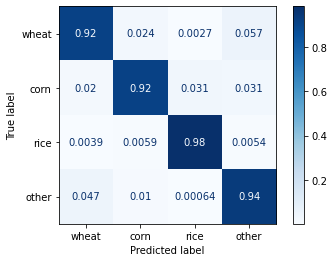

In [36]:
seg_accs_100shots, seg_model_100shots = train_segment(x_few, y_few, x_test, 
                                                       y_test, name='seg_model_100shots_CM.png')

### Band

run 0 :  0.9215183
run 1 :  0.9238267
run 2 :  0.9238325
run 3 :  0.917985
run 4 :  0.91936916
run 5 :  0.91636914
run 6 :  0.9207942
run 7 :  0.9195125
run 8 :  0.9247175
run 9 :  0.9197525
run 10 :  0.9246308
run 11 :  0.92113084
run 12 :  0.9195542
run 13 :  0.9232567
run 14 :  0.9231967
run 15 :  0.92341167
run 16 :  0.9212475
run 17 :  0.92175835
run 18 :  0.923445
run 19 :  0.92351586
run 20 :  0.92018664
run 21 :  0.92864335
run 22 :  0.9175125
run 23 :  0.924045
run 24 :  0.92329
run 25 :  0.92157084
run 26 :  0.92218
run 27 :  0.917985
run 28 :  0.921055
run 29 :  0.9195433
mean src:  0.92162794 	 std:  0.0026125896
              precision    recall  f1-score   support

       wheat       0.94      0.87      0.90    300000
        corn       0.91      0.92      0.91    300000
        rice       0.97      0.98      0.97    300000
       other       0.87      0.91      0.89    300000

    accuracy                           0.92   1200000
   macro avg       0.92      0.92      0.

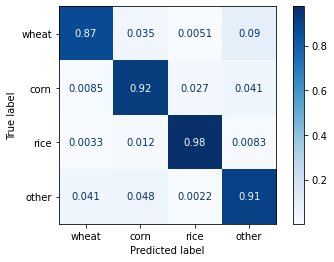

In [37]:
band_accs_100shots, band_model_100shots = train_band(x_few, y_few, x_test, 
                                                       y_test, name='band_model_100shots_CM.png')

### All tasks

run 0 :  0.9424025
run 1 :  0.9404708
run 2 :  0.93525416
run 3 :  0.9432283
run 4 :  0.93714
run 5 :  0.92225665
run 6 :  0.9373133
run 7 :  0.93839335
run 8 :  0.9389733
run 9 :  0.93244416
run 10 :  0.94034165
run 11 :  0.9405375
run 12 :  0.93854
run 13 :  0.9380375
run 14 :  0.9379633
run 15 :  0.9373533
run 16 :  0.93575
run 17 :  0.93743
run 18 :  0.9411175
run 19 :  0.93437
run 20 :  0.93779415
run 21 :  0.93534166
run 22 :  0.9227175
run 23 :  0.9329967
run 24 :  0.93821335
run 25 :  0.9402958
run 26 :  0.9427417
run 27 :  0.9412442
run 28 :  0.9375733
run 29 :  0.93993664
mean src:  0.93727237 	 std:  0.0048223115
              precision    recall  f1-score   support

       wheat       0.93      0.91      0.92    300000
        corn       0.92      0.95      0.94    300000
        rice       0.98      0.98      0.98    300000
       other       0.93      0.92      0.92    300000

    accuracy                           0.94   1200000
   macro avg       0.94      0.94      0.9

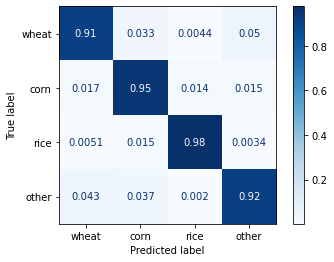

In [38]:
mt_accs_100shots, mt_model_100shots = train_multitask(x_few, y_few, x_test, 
                                                       y_test, name='all_model_100shots_CM.png')